nodes.shape=(5, 5, 2)


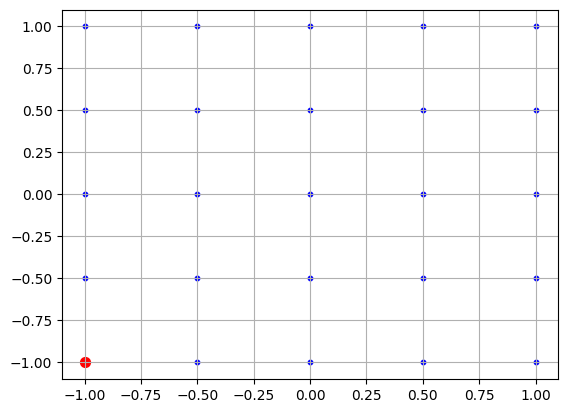

In [1]:
from matplotlib import pyplot as plt
import numpy as np

# Chose number of robots
k = 5
# Chose recharging proportionality constant
q_k = 0.1  # This means that each robot will need to charge for 10 minutes for every 100 minutes travelled
# Chose the number of nodes in an axis
n = 5
# Create a uniform (n, n, 2) numpy grid for MAXIMUM SPEED
nodes = np.mgrid[-1:1:n * 1j, -1.:1:n * 1j]
nodes = nodes.reshape(nodes.shape + (1,))
nodes = np.concatenate((nodes[0], nodes[1]), axis=2)
# nodes = nodes.reshape((1,) + nodes.shape)
# nodes = np.concatenate([nodes for _ in range(k)], axis=0)
print(f"{nodes.shape=}")

# nodes = targets + depots
# Note: If a node isn't a depot, it is a target

# Specify depots
## One depot node
depot_indices = np.array([[0, 0]])
## Four depot nodes (one in each corner)
# depot_indices = np.array([[0, 0], [n-1,n-1], [0, n-1], [n-1, 0]])
# print(f"{depot_indices=}")
target_indices = []
for i in range(n):
    for j in range(n):
        is_depot = False
        for depot in depot_indices:
            if i == depot[0] and j == depot[1]:
                is_depot = True
                continue
        if not is_depot:
            target_indices.append([i,j])
target_indices = np.array(target_indices)
# print(f"{target_indices=}")

# Chose starting depot node
# Make all robots start from same depot
B_k = np.array([depot_indices[0]] * k)
# Make depots start from multiple depots
# B_k = depot_indices[:k]
# print(f"{B_k=}")

# Graphical sanity check
plt.figure()
plt.scatter(nodes[:,:,0], nodes[:,:,1], c='blue', s=10)
plt.scatter(nodes[depot_indices[:,0],depot_indices[:,1],0], nodes[depot_indices[:,0],depot_indices[:,1], 1], c='red', s=50)
plt.grid()
plt.show()

In [2]:
import itertools

# Calculate c_{i1,j1,i2,j2} (c[i1, j1, i2, j2] is the cost (including recharging, q_k) from TARGET and DEPOT nodes (i1, j1) to (i2, j2))
cost = np.zeros((n,n,n,n))
for i1, j1, i2, j2 in itertools.product(range(n), range(n), range(n), range(n)):
    cost[i1,j1,i2,j2] = np.sqrt((nodes[i1,j1,0]-nodes[i2,j2,0]) ** 2 + (nodes[i1,j1,1]-nodes[i2,j2,1]) ** 2)
    # print(f"({i1},{j1},{i2},{j2}):({targets[i1,j1,0]},{targets[i1,j1,1]},{targets[i2,j2,0]},{targets[i2,j2,1]}): {target_cost[i1,j1,i2,j2]}")
print(f"{cost.shape=}")

cost.shape=(5, 5, 5, 5)


In [3]:
import gurobipy as gp
from gurobipy import GRB

m = gp.Model()

# A. Integer Constraints (4), (5)
x = m.addMVar((k,n,n,n,n), name='x', vtype=GRB.INTEGER, lb=0, ub=len(target_indices))
for i1, j1, i2, j2 in itertools.product(range(n), range(n), range(n), range(n)):
    are_both_depot = False
    for d1 in depot_indices:
        if d1[0] != i1 or d1[1] != j1 : continue
        for d2 in depot_indices:
            if d2[0] != i2 or d2[1] != j2: continue
            are_both_depot = True
    if not are_both_depot:
        for ki in range(k):
            _ = m.addConstr(x[ki,i1,j1,i2,j2] <= 1)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2421738
Academic license 2421738 - for non-commercial use only - registered to sd___@wpi.edu


In [4]:
# B. Degree Constraints (6), (7), (8), (9), (10)
# (6) and (7) Only one robot arrives to and leaves from a target (B_k is a depot, so we don't need to remove it from targets)
_ = m.addConstrs(x[:,i1,j1,:,:].sum() == 1 for i1, j1 in target_indices)
_ = m.addConstrs(x[:,:,:,i1,j1].sum() == 1 for i1, j1 in target_indices)

for ki in range(k):
    # (8) and (9) Begin and end at same position B_k
    # _ = m.addConstr(x[ki,B_k[ki,0],B_k[ki,1],:,:].sum() >= 1)
    _ = m.addConstr(x[ki,B_k[ki,0],B_k[ki,1],:,:].sum() <= 1)
    # _ = m.addConstr(x[ki,:,:,B_k[ki,0],B_k[ki,1]].sum() >= 1)
    _ = m.addConstr(x[ki,:,:,B_k[ki,0],B_k[ki,1]].sum() <= 1)

    # (10) Every robot that visits a target leaves the target
    _ = m.addConstrs((x[ki,:,:,i1,j1]-x[ki,i1,j1,:,:]).sum() == 0 for i1 in range(n) for j1 in range(n))

    # Additional constraint: no loopholes!
    _ = m.addConstrs(x[ki, i, j, i, j] == 0 for i in range(n) for j in range(n))

In [5]:
# C. Capacity and Flow Constraints (11), (12), (13), (14)
p = m.addMVar((k,n,n,n,n), name='p', vtype=GRB.INTEGER, lb=0, ub=len(target_indices))

for ki in range(k):
    # (11) and (12) flow constraints
    # Note used N/B_k instead of D/B_k
    right_side = 0
    for i1, j1, i2, j2 in itertools.product(range(n), range(n), range(n), range(n)):
        if i1 == B_k[ki,0] and j1 == B_k[ki,1]:
            continue
        right_side += x[ki,i1,j1,i2,j2]
    _ = m.addConstr((p[ki,B_k[ki,0],B_k[ki,1],:,:] - p[ki,:,:,B_k[ki,0],B_k[ki,1]]).sum() == right_side)

    for i1, j1 in itertools.product(range(n), range(n)):
        if i1 == B_k[ki,0] and j1 == B_k[ki,1]:
            continue
        _ = m.addConstr((p[ki,:,:,i1,j1] - p[ki,i1,j1,:,:]).sum() == x[ki,i1,j1,:,:].sum())

    # (13) Make sure target capacity doesn't change when passing through a depot
    # Note: Disable for now because we only have one depot which is the starting point
    # for i, (i1, j1) in enumerate(depot_indices):
    #     if i == ki: continue  # Why? See: https://github.com/NESTLab/mrpcp#linear-constraints
    #     left_side = 0
    #     for i2, j2 in itertools.product(range(n), range(n)):
    #         left_side += p[ki,i2,j2,i1,j1] - p[ki,i1,j1,i2,j2]
    #     _ = m.addConstr(left_side == 0)

    # (14) Ensure that target capacity for each robot doesn't exceed |T|
    _ = m.addConstrs(p[ki,i1,j1,i2,j2] <= len(target_indices) * x[ki,i1,j1,i2,j2] for i1 in range(n) for j1 in range(n) for i2 in range(n) for j2 in range(n))

In [6]:
# # D. Fuel Constraints (15), (16), (17), (18), (19), (20)
max_fuel_cost_to_node = np.sqrt(8)  # √8 is the max possible distance between our nodes (-1, -1) and (1, 1)
L = max_fuel_cost_to_node * 4  # Fuel capacity (1 unit of fuel = 1 unit of distance)
M = L + max_fuel_cost_to_node
r = m.addMVar((n,n), name='r', vtype=GRB.CONTINUOUS, lb=0, ub=L) # (20)

for ki in range(k):
    # (15) and (16)
    _ = m.addConstrs(r[i2,j2] - r[i1,j1] + cost[i1,j1,i2,j2] <=  M * (1 - x[ki,i1,j1,i2,j2]) for i1, j1 in target_indices for i2, j2 in target_indices)
    _ = m.addConstrs(r[i2,j2] - r[i1,j1] + cost[i1,j1,i2,j2] >= -M * (1 - x[ki,i1,j1,i2,j2]) for i1, j1 in target_indices for i2, j2 in target_indices)

    # (17) and (18)
    _ = m.addConstrs(r[i2,j2] - L + cost[i1,j1,i2,j2] >= -M * (1 - x[ki,i1,j1,i2,j2]) for i1, j1 in depot_indices for i2, j2 in target_indices)
    _ = m.addConstrs(r[i2,j2] - L + cost[i1,j1,i2,j2] <=  M * (1 - x[ki,i1,j1,i2,j2]) for i1, j1 in depot_indices for i2, j2 in target_indices)

    # (19)
    _ = m.addConstrs(r[i1,j1] - cost[i1,j1,i2,j2] >= -M * (1 - x[ki,i1,j1,i2,j2]) for i1, j1 in target_indices for i2, j2 in depot_indices)

In [7]:
# Set objective function (3)
# minimize maximum tour per robot
p_max = m.addVar(vtype=GRB.CONTINUOUS, name="p_max")
_ = m.addConstrs((cost * x[ki]).sum() <= p_max for ki in range(k))
m.setObjective(p_max)

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_tsp_paths(tsp_edges):
    k = len(tsp_edges)
    n = len(tsp_edges[0])

    # Check if all elements are either 0 or 1
    if not np.all(np.isin(tsp_edges, [0, 1])):
        print("No TSP paths to visualize.")
        return

    tsp_paths = [np.where(np.isclose(path, 1))[0][0] for path in tsp_edges]

    for i in range(k):
        plot_path(tsp_edges[i], n, label=f"Robot {i + 1} TSP Path")

    plt.title("TSP Paths on a n x n Grid")
    plt.xlabel("X-axis (Node Columns)")
    plt.ylabel("Y-axis (Node Rows)")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_path(path, n, label):
    # Extract indices of nodes in the path
    path_indices = np.where(np.isclose(path, 1))[0]

    # Create a grid for visualization
    grid = np.zeros((n, n))

    # Mark covered nodes on the grid
    for idx in path_indices:
        row, col = divmod(idx, 5)
        grid[row, col] = 1

    # Get coordinates of covered nodes
    covered_nodes = np.column_stack(np.where(grid == 1))

    # Plot the TSP path with connected nodes and edges
    plt.scatter(covered_nodes[:, 1], covered_nodes[:, 0], label=label, s=100, marker='o')
    for i in range(len(path_indices) - 1):
        plt.plot(covered_nodes[i:i+2, 1], covered_nodes[i:i+2, 0], color='blue', linestyle='-', linewidth=2)
        
# visualize_tsp_paths([[0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0]])


In [9]:
# import datetime
def visualize_paths_brute_force(edges):
    active_robots = []
    for robot_index in range(k):
        print("Shape of edges:", edges.shape)
        print("Shape of edges[robot_index]:", np.array(edges[robot_index]).shape)
        if (cost * edges[ki]).sum() > 0.01:
            active_robots.append(robot_index)

    subplot_per_hor_axis = int(np.ceil(np.sqrt(len(active_robots))))
    subplot_per_vert_axis = int(np.ceil(len(active_robots) / subplot_per_hor_axis))
    fig, axs = plt.subplots(subplot_per_hor_axis, subplot_per_vert_axis, figsize=(subplot_per_hor_axis * 4, subplot_per_vert_axis * 4))
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.1, top=0.9, right=0.9, left=0.1, wspace=0.3, hspace=0.3)

    hor_i = 0
    vert_i = 0
    for i, robot_index in enumerate(active_robots):
        # print(f"Robot #{ki}\n-------")
        # print(f"Staring position: {B_k[ki]} -> {[nodes[B_k[ki, 0], B_k[ki, 1], 0], nodes[B_k[ki, 0], B_k[ki, 1], 1]]}")
        ax = axs[hor_i][vert_i]
        ax.set_title(f"Robot #{i+1} (cost={(cost * edges[robot_index]).sum():.3f})")
        ax.scatter(nodes[:, :, 0], nodes[:, :, 1], c='blue', s=10)
        ax.scatter(nodes[depot_indices[:, 0], depot_indices[:, 1], 0], nodes[depot_indices[:, 0], depot_indices[:, 1], 1], c='red', s=50)
        ax.scatter(nodes[B_k[robot_index, 0], B_k[robot_index, 1], 0], nodes[B_k[robot_index, 0], B_k[robot_index, 1], 1], c='red', s=100)

        for i1, j1, i2, j2 in itertools.product(range(n), range(n), range(n), range(n)):
            if edges[robot_index,i1, j1, i2, j2] > 0.5:  # In case there is any floating math errors
                # print(f"Connection from {[i1,j1]} to {[i2,j2]}")
                ax.scatter(nodes[i1, j1, 0], nodes[i1, j1, 1], c="purple", s=8)
                ax.scatter(nodes[i2, j2, 0], nodes[i2, j2, 1], c="purple", s=8)
                ax.plot([nodes[i1, j1, 0], nodes[i2, j2, 0]], [nodes[i1, j1, 1], nodes[i2, j2, 1]], color="purple", linewidth=1)

        vert_i += 1
        if vert_i >= subplot_per_vert_axis:
            vert_i = 0
            hor_i += 1
        ax.grid()

    for h in range(subplot_per_hor_axis):
        for v in range(subplot_per_vert_axis):
            ax = axs[h][v]
            ax.set_box_aspect(1)

    fig.suptitle(f"Paths for all robots (# of active/available robots={len(active_robots)}/{k}, sum of costs={(cost * edges).sum():.3f})")
    # fig.savefig(f"../../data/2015_mrpcp_k={k}_n={n}_{datetime.datetime.now().strftime('%Y-%m-%d-%H:%M:%S')}.png") 
    plt.show()

In [10]:
import gurobipy as grb

def create_tsp_model(subtour_lengths):
    n = len(subtour_lengths)

    # Create a new model
    tsp_model = grb.Model()

    # Create binary decision variables for each edge
    x = tsp_model.addMVar((n, n), vtype=grb.GRB.BINARY, name="x")

    # Update model to incorporate variables
    tsp_model.update()

    # Set objective: minimize total distance
    obj_expr = grb.LinExpr()
    for i in range(n):
        for j in range(n):
            if i != j:
                coefficient = np.sum(subtour_lengths[i][j])  # Convert array to scalar
                variable = x[i, j]
                obj_expr += coefficient * variable
    tsp_model.setObjective(obj_expr, grb.GRB.MINIMIZE)

    # Add constraint: each node has exactly one outgoing edge
    tsp_model.addConstrs(grb.quicksum(x[i, j] for j in range(n)) == 1 for i in range(n))

    # Add constraint: each node has exactly one incoming edge
    tsp_model.addConstrs(grb.quicksum(x[i, j] for i in range(n)) == 1 for j in range(n))

    # Add subtour elimination constraints to prevent cycles
    tsp_model.addConstrs((x[i, j] + x[j, i] <= 1) for i in range(n) for j in range(n) if i != j)

    # Disable Gurobi logging to the console
    tsp_model.Params.LogToConsole = 0  
    
    tsp_model._x = x

    return tsp_model

In [11]:
class MILPSolver:
    min_cost_edges = None
    min_cost = np.inf

    def __init__(self, model):
        self.model = model

    @staticmethod
    def cb(what, where):
        if where == GRB.Callback.MIPSOL and what.cbGet(GRB.Callback.MIPSOL_OBJ) < MILPSolver.min_cost:
            MILPSolver.min_cost = what.cbGet(GRB.Callback.MIPSOL_OBJ)
            print(f"Found a new solution with lower cost({MILPSolver.min_cost:.3f})!")
            MILPSolver.min_cost_edges = what.cbGetSolution(what._x)
            visualize_paths_brute_force(MILPSolver.min_cost_edges)
            
            # Run TSP optimization for each robot's subtour
            tsp_edges = np.zeros(MILPSolver.min_cost_edges.shape)
            for ki in range(k):
                tsp_model = create_tsp_model(MILPSolver.min_cost_edges[ki])
                tsp_model.optimize()
                print("Model status:", tsp_model.status)
            
                # # Retrieve solution after optimization
                # tsp_edges = [[tsp_model.getVarByName(f'x[{i},{j}]').X for j in range(n)] for i in range(n)]
                # tsp_edges = np.round(tsp_edges)
                # tsp_edges = tsp_edges.tolist()  # Convert NumPy array to list
            
                # Visualize paths for TSP edges
                # print("tsp_edges:", tsp_edges)
                print(f"{tsp_model._x.X.shape=}")
                tsp_edges[ki,:,:] = tsp_model._x[:,:].X
            visualize_paths_brute_force(tsp_edges)


            # If this solution's maximum costing tour ~= the cost of the tour that only travels between depot and the furthest node,
            # then, this is guaranteed to be optimal.
            if (MILPSolver.min_cost - max_fuel_cost_to_node * 2) < 0.01:
                print("!This is guaranteed to be the optimal solution!")                    
                what.terminate()

    def solve(self):
        self.model.optimize(MILPSolver.cb)


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M3 Max
Thread count: 14 physical cores, 14 logical processors, using up to 14 threads

Academic license 2421738 - for non-commercial use only - registered to sd___@wpi.edu
Optimize a model with 12803 rows, 6276 columns and 54270 nonzeros
Model fingerprint: 0xe36db070
Variable types: 26 continuous, 6250 integer (0 binary)
Coefficient statistics:
  Matrix range     [5e-01, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+01, 2e+01]
  RHS range        [1e+00, 2e+01]
Presolve removed 3610 rows and 251 columns
Presolve time: 0.03s
Presolved: 9193 rows, 6025 columns, 49850 nonzeros
Variable types: 25 continuous, 6000 integer (3000 binary)

Root relaxation: objective 2.541421e+00, 4759 iterations, 0.25 seconds (0.90 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.5414

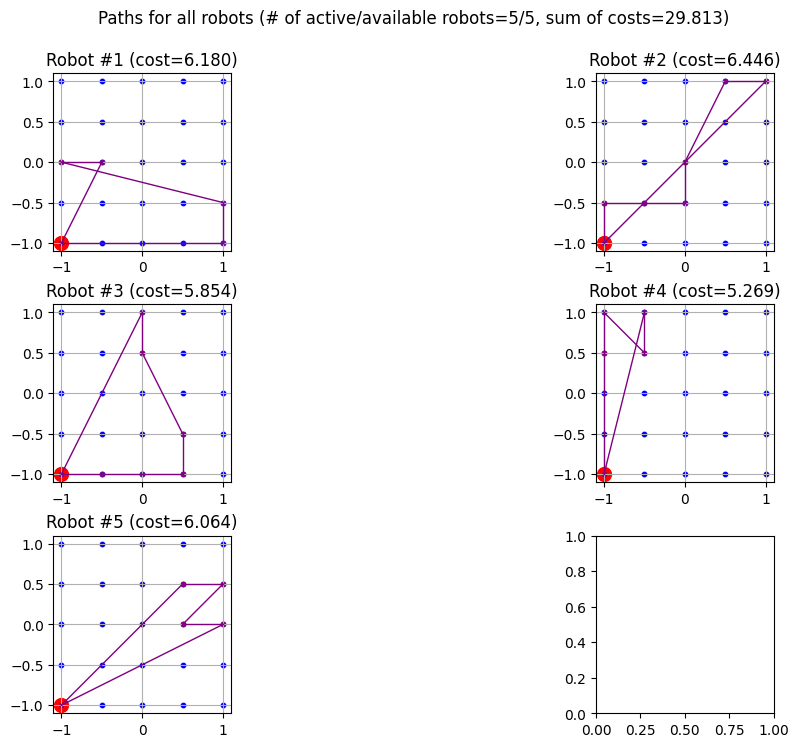

Model status: 2
tsp_model._x.X.shape=(5, 5)
Model status: 2
tsp_model._x.X.shape=(5, 5)
Model status: 2
tsp_model._x.X.shape=(5, 5)
Model status: 2
tsp_model._x.X.shape=(5, 5)
Model status: 2
tsp_model._x.X.shape=(5, 5)
Shape of edges: (5, 5, 5, 5, 5)
Shape of edges[robot_index]: (5, 5, 5, 5)
Shape of edges: (5, 5, 5, 5, 5)
Shape of edges[robot_index]: (5, 5, 5, 5)
Shape of edges: (5, 5, 5, 5, 5)
Shape of edges[robot_index]: (5, 5, 5, 5)
Shape of edges: (5, 5, 5, 5, 5)
Shape of edges[robot_index]: (5, 5, 5, 5)
Shape of edges: (5, 5, 5, 5, 5)
Shape of edges[robot_index]: (5, 5, 5, 5)


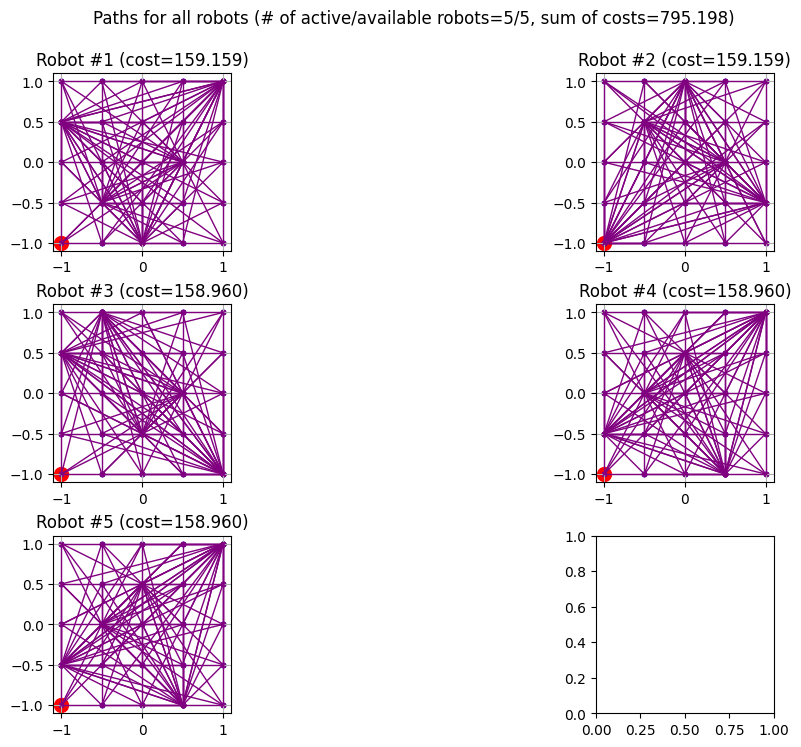

H    0     0                       6.4464611    2.54142  60.6%     -    3s
     0     0    2.54142    0  274    6.44646    2.54142  60.6%     -    4s
     0     0    2.54142    0  270    6.44646    2.54142  60.6%     -    4s
Found a new solution with lower cost(6.288)!
Shape of edges: (5, 5, 5, 5, 5)
Shape of edges[robot_index]: (5, 5, 5, 5)
Shape of edges: (5, 5, 5, 5, 5)
Shape of edges[robot_index]: (5, 5, 5, 5)
Shape of edges: (5, 5, 5, 5, 5)
Shape of edges[robot_index]: (5, 5, 5, 5)
Shape of edges: (5, 5, 5, 5, 5)
Shape of edges[robot_index]: (5, 5, 5, 5)
Shape of edges: (5, 5, 5, 5, 5)
Shape of edges[robot_index]: (5, 5, 5, 5)


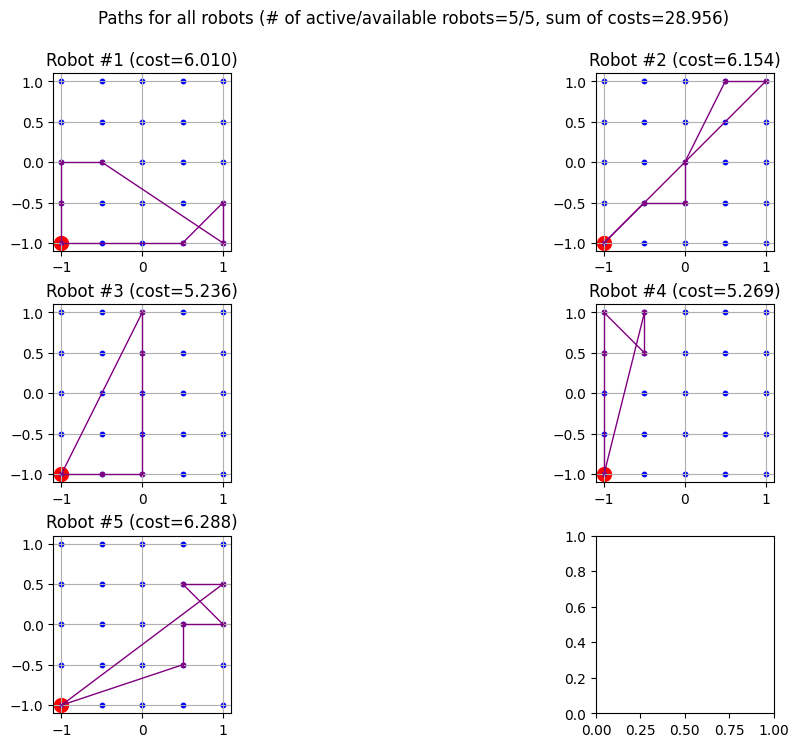

Model status: 2
tsp_model._x.X.shape=(5, 5)
Model status: 2
tsp_model._x.X.shape=(5, 5)
Model status: 2
tsp_model._x.X.shape=(5, 5)
Model status: 2
tsp_model._x.X.shape=(5, 5)
Model status: 2
tsp_model._x.X.shape=(5, 5)
Shape of edges: (5, 5, 5, 5, 5)
Shape of edges[robot_index]: (5, 5, 5, 5)
Shape of edges: (5, 5, 5, 5, 5)
Shape of edges[robot_index]: (5, 5, 5, 5)
Shape of edges: (5, 5, 5, 5, 5)
Shape of edges[robot_index]: (5, 5, 5, 5)
Shape of edges: (5, 5, 5, 5, 5)
Shape of edges[robot_index]: (5, 5, 5, 5)
Shape of edges: (5, 5, 5, 5, 5)
Shape of edges[robot_index]: (5, 5, 5, 5)


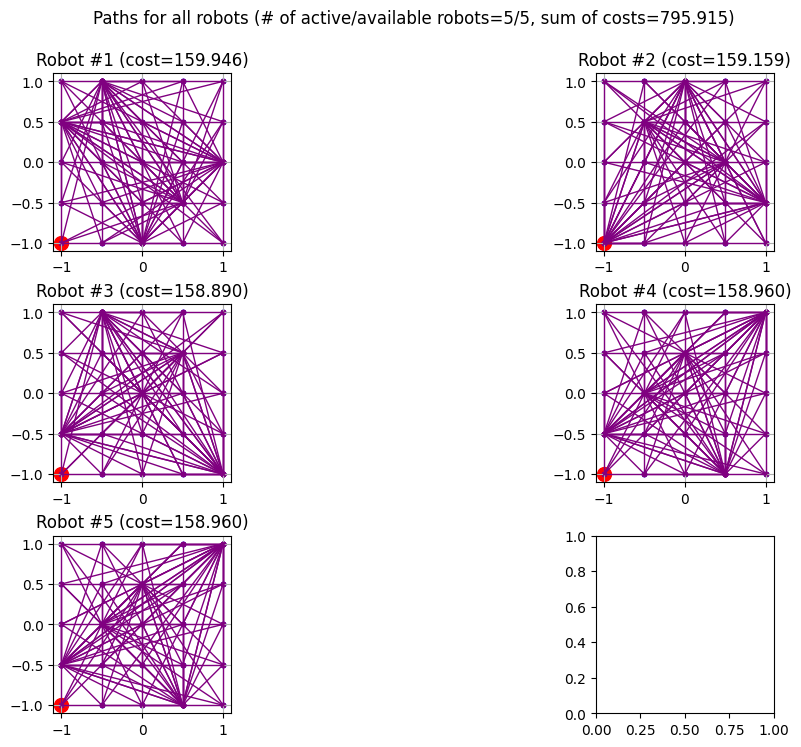

H    0     0                       6.2882456    2.54142  59.6%     -    8s
     0     0    2.54142    0  185    6.28825    2.54142  59.6%     -    8s
Found a new solution with lower cost(6.064)!
Shape of edges: (5, 5, 5, 5, 5)
Shape of edges[robot_index]: (5, 5, 5, 5)
Shape of edges: (5, 5, 5, 5, 5)
Shape of edges[robot_index]: (5, 5, 5, 5)
Shape of edges: (5, 5, 5, 5, 5)
Shape of edges[robot_index]: (5, 5, 5, 5)
Shape of edges: (5, 5, 5, 5, 5)
Shape of edges[robot_index]: (5, 5, 5, 5)
Shape of edges: (5, 5, 5, 5, 5)
Shape of edges[robot_index]: (5, 5, 5, 5)


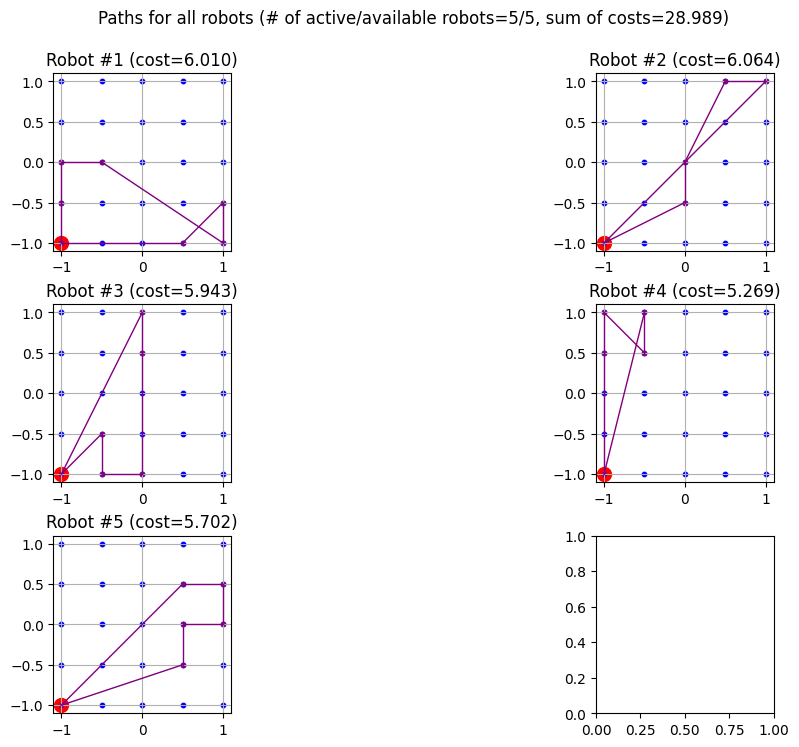

Model status: 2
tsp_model._x.X.shape=(5, 5)
Model status: 2
tsp_model._x.X.shape=(5, 5)
Model status: 2
tsp_model._x.X.shape=(5, 5)
Model status: 2
tsp_model._x.X.shape=(5, 5)
Model status: 2
tsp_model._x.X.shape=(5, 5)
Shape of edges: (5, 5, 5, 5, 5)
Shape of edges[robot_index]: (5, 5, 5, 5)
Shape of edges: (5, 5, 5, 5, 5)
Shape of edges[robot_index]: (5, 5, 5, 5)
Shape of edges: (5, 5, 5, 5, 5)
Shape of edges[robot_index]: (5, 5, 5, 5)
Shape of edges: (5, 5, 5, 5, 5)
Shape of edges[robot_index]: (5, 5, 5, 5)
Shape of edges: (5, 5, 5, 5, 5)
Shape of edges[robot_index]: (5, 5, 5, 5)


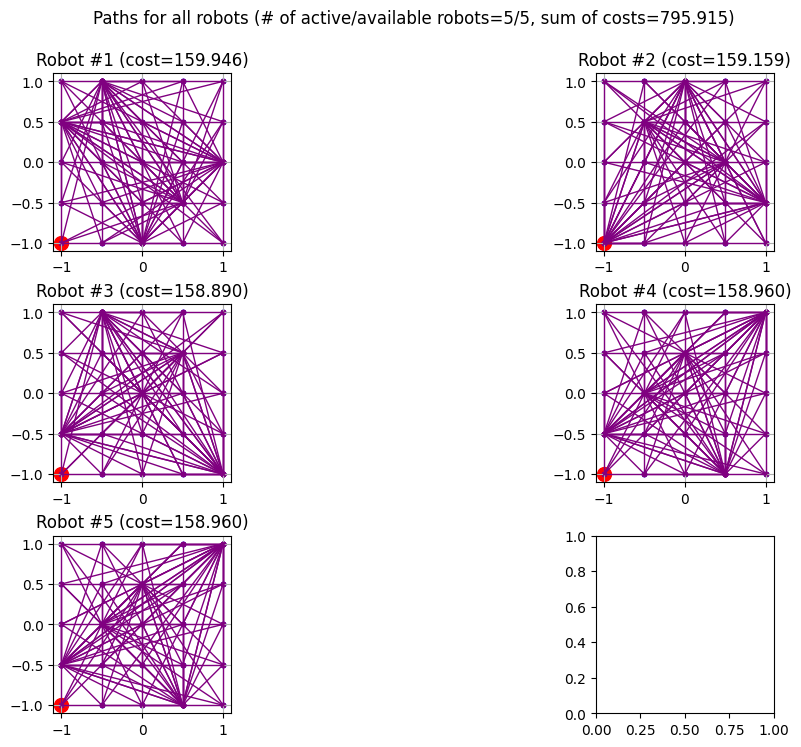

H    0     0                       6.0644951    2.54142  58.1%     -   11s
     0     0    2.54142    0  244    6.06450    2.54142  58.1%     -   11s
     0     0    2.54142    0  195    6.06450    2.54142  58.1%     -   12s
     0     0    2.54142    0  290    6.06450    2.54142  58.1%     -   12s
Found a new solution with lower cost(6.010)!
Shape of edges: (5, 5, 5, 5, 5)
Shape of edges[robot_index]: (5, 5, 5, 5)
Shape of edges: (5, 5, 5, 5, 5)
Shape of edges[robot_index]: (5, 5, 5, 5)
Shape of edges: (5, 5, 5, 5, 5)
Shape of edges[robot_index]: (5, 5, 5, 5)
Shape of edges: (5, 5, 5, 5, 5)
Shape of edges[robot_index]: (5, 5, 5, 5)
Shape of edges: (5, 5, 5, 5, 5)
Shape of edges[robot_index]: (5, 5, 5, 5)


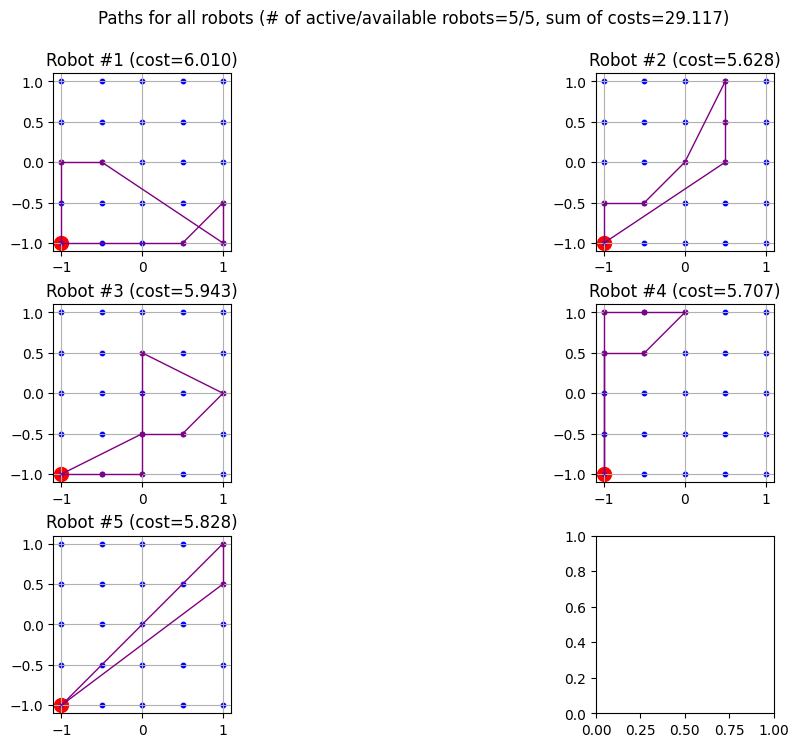

Model status: 2
tsp_model._x.X.shape=(5, 5)
Model status: 2
tsp_model._x.X.shape=(5, 5)
Model status: 2
tsp_model._x.X.shape=(5, 5)
Model status: 2
tsp_model._x.X.shape=(5, 5)
Model status: 2
tsp_model._x.X.shape=(5, 5)
Shape of edges: (5, 5, 5, 5, 5)
Shape of edges[robot_index]: (5, 5, 5, 5)
Shape of edges: (5, 5, 5, 5, 5)
Shape of edges[robot_index]: (5, 5, 5, 5)
Shape of edges: (5, 5, 5, 5, 5)
Shape of edges[robot_index]: (5, 5, 5, 5)
Shape of edges: (5, 5, 5, 5, 5)
Shape of edges[robot_index]: (5, 5, 5, 5)
Shape of edges: (5, 5, 5, 5, 5)
Shape of edges[robot_index]: (5, 5, 5, 5)


In [ ]:
# Optimize until the first optimal solution is found
m._x = x
solver = MILPSolver(m)
solver.solve()
# visualize_paths_brute_force(MILPSolver.min_cost_edges)
